In [1]:
CONFIG_FILE_PATH = "config/config.yml"

In [2]:
from pathlib import Path

import yaml
from pyarrow.parquet import ParquetFile
import pyarrow as pa

import pandas as pd

In [3]:
# Mapping of metadata keys to filename prefixes and data types
FILENAME_METADATA_MAPPING = {
    "plate": ["P-", str],
    "well": ["W-", str],
    "tile": ["T-", int],
    "cycle": ["C-", int],
    "gene": ["G-", str],
    "sgrna": ["SG-", str],
    "channel": ["CH-", str],
    "dataset": ["DT-", str],
}


def get_filename(data_location: dict, info_type: str, file_type: str) -> str:
    """Generate a structured filename based on data location, information type, and file type.

    Args:
        data_location (dict): Dictionary containing location info like well, tile, and cycle.
        info_type (str): Type of information (e.g., 'cell_features', 'sbs_reads').
        file_type (str): File extension/type (e.g., 'tsv', 'parquet', 'tiff').

    Returns:
        str: Structured filename.
    """
    parts = []

    for metadata_key, metadata_value in data_location.items():
        if metadata_key in FILENAME_METADATA_MAPPING:
            prefix, _ = FILENAME_METADATA_MAPPING[metadata_key]
            parts.append(f"{prefix}{metadata_value}")
        else:
            print(f"Unknown metadata key: {metadata_key}")

    prefix = "_".join(parts)
    filename = (
        f"{prefix}__{info_type}.{file_type}" if prefix else f"{info_type}.{file_type}"
    )

    return filename


def load_parquet_subset(full_df_fp, n_rows=50000):
    """Load a fixed number of rows from an parquet file without loading entire file into memory.

    Args:
        full_df_fp (str): Path to parquet file.
        n_rows (int): Number of rows to get.

    Returns:
        pd.DataFrame: Subset of the data with combined blocks.
    """
    print(f"Reading first {n_rows:,} rows from {full_df_fp}")

    # read the first n_rows of the file path
    df = ParquetFile(full_df_fp)
    row_subset = next(df.iter_batches(batch_size=n_rows))
    df = pa.Table.from_batches([row_subset]).to_pandas()

    return df

In [4]:
TEST_PLATE = 1
TEST_WELL = "A1"

POPULATION_FEATURE = "gene_symbol_0"

In [5]:
# load config file and determine root path
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)
ROOT_FP = Path(config["all"]["root_fp"])

# Load subset of data
# Takes ~1 minute
merge_final_fp = (
    ROOT_FP
    / "merge"
    / "parquets"
    / get_filename({"plate": TEST_PLATE, "well": TEST_WELL}, "merge_final", "parquet")
)
merge_final = load_parquet_subset(merge_final_fp)
print(f"Unique populations: {merge_final[POPULATION_FEATURE].nunique()}")

display(merge_final)

Reading first 50,000 rows from analysis_root/merge/parquets/P-1_W-A1__merge_final.parquet
Unique populations: 4601


,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cell_number_neighbors_1,cell_percent_touching_1,cell_first_neighbor_distance,cell_second_neighbor_distance,cell_angle_between_neighbors,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
0,1,A1,1045,429,1478.403947,1481.714474,243,254,100.607843,670.117647,...,0,0.000000,48.501317,54.812638,164.492958,0.0,0.000000,48.482563,55.773102,160.427741
1,1,A1,401,485,1477.766431,1478.877654,101,294,100.089552,669.910448,...,1,0.049751,45.269871,62.882030,106.480590,1.0,0.028818,40.760186,57.586665,116.482954
2,1,A1,1502,501,1480.628283,1477.384343,354,277,100.674419,99.806202,...,0,0.000000,50.779623,74.421862,151.065981,0.0,0.000000,52.674577,70.256562,166.276907
3,1,A1,595,475,1480.676399,1482.874696,154,221,100.764706,670.764706,...,2,0.193548,36.794933,52.151249,171.453465,2.0,0.040404,39.327858,47.072292,154.575718
4,1,A1,1479,601,1477.695030,1481.850904,365,346,99.764045,671.494382,...,0,0.000000,57.697175,61.333366,138.748450,0.0,0.000000,62.644570,63.731803,133.933684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1,A1,1125,453,1480.076923,1755.965545,278,220,100.432099,168.814815,...,1,0.027778,51.719049,57.920520,168.921134,1.0,0.015625,52.825726,62.730908,168.160355
49996,1,A1,1408,731,1753.173077,1440.839744,338,2338,739.098765,92.271605,...,0,0.000000,63.654194,75.970693,59.774914,0.0,0.000000,65.328179,79.941206,91.112332
49997,1,A1,525,334,1227.967429,1592.447678,120,1347,608.121212,697.919192,...,0,0.000000,52.176829,59.403882,169.852034,0.0,0.000000,49.825625,59.247234,172.702028
49998,1,A1,56,503,1600.628225,1728.227618,19,350,130.087379,160.582524,...,0,0.000000,60.944246,69.059469,44.366065,0.0,0.000000,62.061594,64.824308,55.486461


In [6]:
print("First 20 columns; use to set parameters below.")
for index, col in enumerate(merge_final.columns[:20]):
    print(index, col)

First 20 columns; use to set parameters below.
0 plate
1 well
2 tile
3 cell_0
4 i_0
5 j_0
6 site
7 cell_1
8 i_1
9 j_1
10 distance
11 fov_distance_0
12 fov_distance_1
13 sgRNA_0
14 gene_symbol_0
15 mapped_single_gene
16 channels_min
17 nucleus_DAPI_int
18 nucleus_COXIV_int
19 nucleus_CENPA_int


In [7]:
def perturbation_filter(
    cell_data,
    perturbation_name_col,
    perturbation_multi_col=None,
    filter_single_pert=False,
):
    """Clean cell data by removing cells without perturbation assignments and optionally filtering for single-gene cells.

    Args:
        cell_data (pd.DataFrame): Raw dataframe containing cell measurements.
        perturbation_name_col (str): Column name containing perturbation assignments.
        perturbation_multi_col (str): If not None, only keep cells with perturbation_multi_col=True.

    Returns:
        pd.DataFrame: Cleaned dataframe.
    """
    # Remove cells without perturbation assignments
    clean_cell_data = cell_data[cell_data[perturbation_name_col].notna()].copy()
    print(f"Found {len(clean_cell_data)} cells with assigned perturbations")

    if filter_single_pert:
        # Filter for single-gene cells if requested
        clean_cell_data = clean_cell_data[
            clean_cell_data[perturbation_multi_col] == True
        ]
        print(f"Kept {len(clean_cell_data)} cells with single gene assignments")
    else:
        # Warn about multi-gene cells if not filtering
        multi_pert_cells = len(
            clean_cell_data[clean_cell_data[perturbation_multi_col] == False]
        )
        if multi_pert_cells > 0:
            print(
                f"WARNING: {multi_pert_cells} cells have multiple perturbation assignments"
            )

    return clean_cell_data

In [8]:
PERTURBATION_NAME_COL = "gene_symbol_0"
PERTURBATION_MULTI_COL = "mapped_single_gene"
FILTER_SINGLE_PERT = False

perturbation_filtered = perturbation_filter(
    merge_final, PERTURBATION_NAME_COL, PERTURBATION_MULTI_COL, FILTER_SINGLE_PERT
)
perturbation_filtered

Found 22753 cells with assigned perturbations


,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cell_number_neighbors_1,cell_percent_touching_1,cell_first_neighbor_distance,cell_second_neighbor_distance,cell_angle_between_neighbors,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
2,1,A1,1502,501,1480.628283,1477.384343,354,277,100.674419,99.806202,...,0,0.000000,50.779623,74.421862,151.065981,0.0,0.000000,52.674577,70.256562,166.276907
11,1,A1,418,496,1476.375566,1478.313725,109,293,99.071429,99.107143,...,0,0.000000,47.622937,66.673654,164.933186,0.0,0.000000,47.218841,73.716465,172.741491
12,1,A1,1160,592,1480.918072,1475.887550,271,2036,670.875000,100.037500,...,0,0.000000,62.678918,63.863621,71.686607,0.0,0.000000,60.153852,68.126821,69.547069
14,1,A1,1185,543,1484.316222,1478.959617,300,230,101.153846,670.461538,...,0,0.000000,60.341099,60.813897,175.345937,0.0,0.000000,66.581960,67.210621,175.959281
21,1,A1,1448,547,1480.565083,1486.317149,351,1831,671.215385,103.030769,...,1,0.153846,39.735701,56.638368,71.506693,1.0,0.088496,39.549864,55.681246,79.132618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49986,1,A1,831,511,1312.816113,1699.527675,218,154,56.640777,723.864078,...,0,0.000000,65.559405,72.844730,55.674649,0.0,0.000000,56.393234,71.543513,131.394288
49987,1,A1,1017,451,1486.380638,1204.132013,257,200,100.471154,601.057692,...,0,0.000000,45.496332,89.098660,72.976404,0.0,0.000000,34.700716,83.190703,87.296246
49988,1,A1,193,366,1545.828172,1747.975025,38,269,116.857143,736.037594,...,0,0.000000,72.856111,78.369999,33.207179,0.0,0.000000,77.124473,77.180167,38.293143
49991,1,A1,1434,397,1250.568815,1633.331742,327,3453,1185.321839,140.068966,...,0,0.000000,66.324855,71.544292,151.676972,0.0,0.000000,64.961924,67.189967,145.825952


In [9]:
FEATURE_START_IDX = 17

Columns with high NA value percent:
  - cytoplasm_DAPI_mean_frac_0: 15720 NAs (69.09%)
  - cytoplasm_COXIV_mean_frac_0: 15720 NAs (69.09%)
  - cytoplasm_CENPA_mean_frac_0: 15720 NAs (69.09%)
  - cytoplasm_WGA_mean_frac_0: 15720 NAs (69.09%)
  - cytoplasm_DAPI_mean_frac_1: 14838 NAs (65.21%)
  - cytoplasm_COXIV_mean_frac_1: 14838 NAs (65.21%)
  - cytoplasm_CENPA_mean_frac_1: 14838 NAs (65.21%)
  - cytoplasm_WGA_mean_frac_1: 14838 NAs (65.21%)
  - cytoplasm_DAPI_radial_cv_0: 15720 NAs (69.09%)
  - cytoplasm_COXIV_radial_cv_0: 15720 NAs (69.09%)
  - cytoplasm_CENPA_radial_cv_0: 15720 NAs (69.09%)
  - cytoplasm_WGA_radial_cv_0: 15720 NAs (69.09%)
  - cytoplasm_DAPI_radial_cv_1: 14838 NAs (65.21%)
  - cytoplasm_COXIV_radial_cv_1: 14838 NAs (65.21%)
  - cytoplasm_CENPA_radial_cv_1: 14838 NAs (65.21%)
  - cytoplasm_WGA_radial_cv_1: 14838 NAs (65.21%)


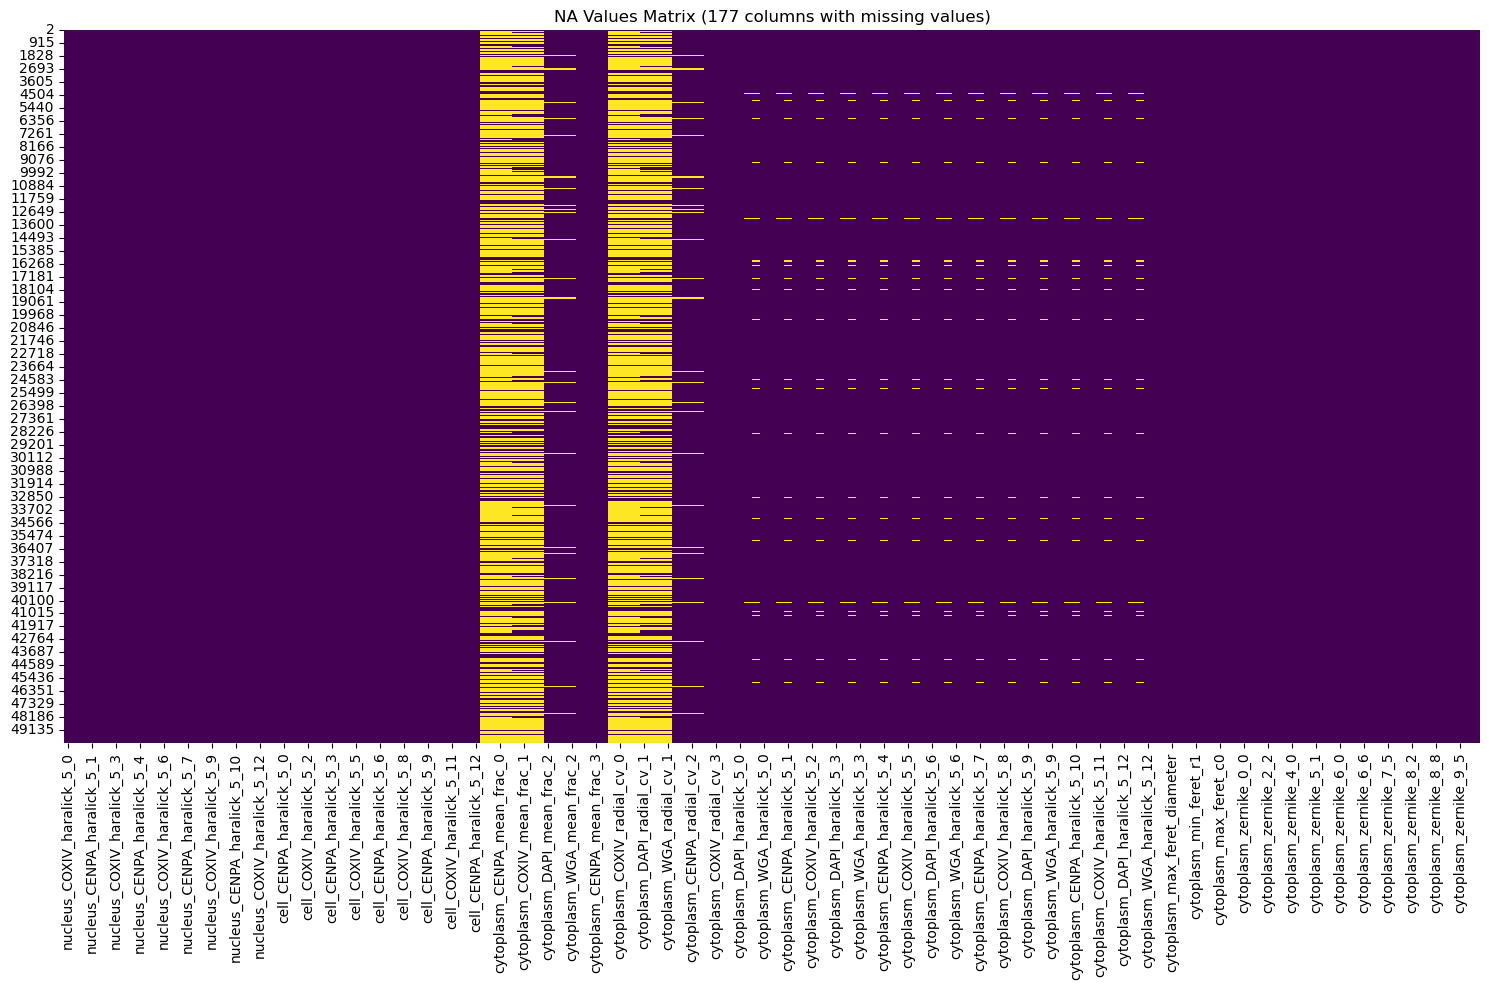

In [24]:
from matplotlib import pyplot as plt
import seaborn as sns

def visualize_na_matrix(df):
    """
    Creates a visualization matrix showing which columns have NA values and in which rows.
    No color bar is displayed.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame to analyze for NA values
        
    Returns:
    --------
    matplotlib.figure.Figure or None
        The figure object if NAs are found, None otherwise
    """
    # Get only columns with at least one NA
    cols_with_na = df.columns[df.isna().any()].tolist()
    
    if not cols_with_na:
        print("No columns with NA values found in the DataFrame.")
        return None
    
    # Create a smaller DataFrame with only columns containing NAs
    na_df = df[cols_with_na].isna()
    
    # Create the heatmap
    plt.figure(figsize=(15, 10))
    plt.title(f"NA Values Matrix ({len(cols_with_na)} columns with missing values)")
    
    # Create heatmap - True (NA) values will be colored, without color bar
    ax = sns.heatmap(na_df, cmap='viridis', cbar=False)
    
    # Display column names on x-axis, rotated for readability
    plt.xticks(rotation=90)
    plt.tight_layout()
    
    # Add summary information
    na_counts = df[cols_with_na].isna().sum()
    na_percent = (na_counts / len(df)) * 100
    
    print(f"Columns with high NA value percent:")
    for col, count, pct in zip(cols_with_na, na_counts, na_percent):
        if pct > 10:
            print(f"  - {col}: {count} NAs ({pct:.2f}%)")
    
    return plt.gcf()

fig = visualize_na_matrix(perturbation_filtered)
plt.show()

In [11]:
DROP_COLS_THRESHOLD = 0.1

In [12]:
from sklearn.covariance import EllipticEnvelope


def intensity_filter(
    cell_data, feature_start_idx, channel_names=None, contamination=0.01
) -> pd.DataFrame:
    """
    Uses EllipticEnvelope to filter outliers by channel intensities.

    Args:
        cell_data (pd.DataFrame): Cell data dataframe.
        feature_start_idx (int): Index of the first feature column.
        channel_names (list[str], optional): A list of channel names to use for intensity filtering. Defaults to None.
        contamination (float, optional): The proportion of outliers to expect. Defaults to 0.01.
    Returns:
        pd.DataFrame: Filtered cell data dataframe.
    """
    # Identify feature cols
    feature_cols = perturbation_filtered.columns[feature_start_idx:].tolist()

    # Determine intensity columns
    intensity_cols = [
        col
        for col in feature_cols
        if any(col.endswith(f"_{channel}_mean") for channel in channel_names)
    ]

    # Fit EllipticEnvelope to intensity cols and get mask
    mask = EllipticEnvelope(contamination=contamination, random_state=42).fit_predict(
        cell_data[intensity_cols]
    )

    # Return filtered cell data
    return cell_data[mask == 1].reset_index(drop=True)

# Load channel names
channel_names = config["phenotype"]["channel_names"]

intensity_filtered = intensity_filter(
    perturbation_filtered, FEATURE_START_IDX, channel_names
)
intensity_filtered

,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cell_number_neighbors_1,cell_percent_touching_1,cell_first_neighbor_distance,cell_second_neighbor_distance,cell_angle_between_neighbors,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
0,1,A1,1502,501,1480.628283,1477.384343,354,277,100.674419,99.806202,...,0,0.000000,50.779623,74.421862,151.065981,0.0,0.000000,52.674577,70.256562,166.276907
1,1,A1,418,496,1476.375566,1478.313725,109,293,99.071429,99.107143,...,0,0.000000,47.622937,66.673654,164.933186,0.0,0.000000,47.218841,73.716465,172.741491
2,1,A1,1160,592,1480.918072,1475.887550,271,2036,670.875000,100.037500,...,0,0.000000,62.678918,63.863621,71.686607,0.0,0.000000,60.153852,68.126821,69.547069
3,1,A1,1185,543,1484.316222,1478.959617,300,230,101.153846,670.461538,...,0,0.000000,60.341099,60.813897,175.345937,0.0,0.000000,66.581960,67.210621,175.959281
4,1,A1,1448,547,1480.565083,1486.317149,351,1831,671.215385,103.030769,...,1,0.153846,39.735701,56.638368,71.506693,1.0,0.088496,39.549864,55.681246,79.132618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22520,1,A1,831,511,1312.816113,1699.527675,218,154,56.640777,723.864078,...,0,0.000000,65.559405,72.844730,55.674649,0.0,0.000000,56.393234,71.543513,131.394288
22521,1,A1,1017,451,1486.380638,1204.132013,257,200,100.471154,601.057692,...,0,0.000000,45.496332,89.098660,72.976404,0.0,0.000000,34.700716,83.190703,87.296246
22522,1,A1,193,366,1545.828172,1747.975025,38,269,116.857143,736.037594,...,0,0.000000,72.856111,78.369999,33.207179,0.0,0.000000,77.124473,77.180167,38.293143
22523,1,A1,1434,397,1250.568815,1633.331742,327,3453,1185.321839,140.068966,...,0,0.000000,66.324855,71.544292,151.676972,0.0,0.000000,64.961924,67.189967,145.825952


In [13]:
from sklearn.impute import KNNImputer

def missing_values_filter(cell_data, feature_start_idx, impute=True, drop_rows=False, drop_cols=False, drop_cols_threshold=None):
    """Filter cell data by handling missing values through dropping or imputation.

    Args:
        cell_data (pd.DataFrame): Raw dataframe containing cell measurements.
        feature_start_idx (int): Index of the first feature column.
        impute (bool): Whether to impute remaining missing values after dropping. Defaults to True.
        drop_rows (bool): Whether to drop all rows with any missing values. Defaults to False.
        drop_cols (bool): Whether to drop all columns with any missing values. Defaults to False.
        drop_cols_threshold (float, optional): If provided, drops columns with NaN proportion >= threshold.
                                              This overrides drop_cols if both are specified.
                                              Range: 0.0-1.0. Defaults to None.

    Returns:
        pd.DataFrame: Filtered dataframe with handled missing values.
    """
    # Get features
    metadata = cell_data.iloc[:, :feature_start_idx].copy()
    features = cell_data.iloc[:, feature_start_idx:].copy()
    
    # Get columns with missing values
    cols_with_na = features.columns[features.isna().any()].tolist()
    
    if not cols_with_na:
        return cell_data
    
    # Perform dropping operations if requested
    if drop_rows:
        # Drop rows with any missing values
        original_row_count = features.shape[0]
        features.dropna(axis=0, inplace=True)
        print(f"Dropped {original_row_count - features.shape[0]} rows with missing values")
        
        # Update metadata to match remaining rows
        metadata = metadata.loc[features.index]
    
    # Handle column dropping based on parameters
    if drop_cols_threshold is not None:
        # Calculate proportion of NaN values in each column
        na_proportions = features.isna().mean()
        
        # Identify columns to drop based on threshold
        cols_to_drop = na_proportions[na_proportions >= drop_cols_threshold].index.tolist()
        
        if cols_to_drop:
            print(f"Dropping {len(cols_to_drop)} columns with ≥{drop_cols_threshold*100}% missing values")
            features.drop(columns=cols_to_drop, inplace=True)
    
    if drop_cols:
        # Drop all columns with any missing values
        print(f"Dropping all {len(cols_with_na)} columns with any missing values")
        features.drop(columns=cols_with_na, inplace=True)
    
    # Impute remaining missing values if requested
    if impute:
        # Get updated list of columns with missing values
        remaining_cols_with_na = features.columns[features.isna().any()].tolist()
        
        if remaining_cols_with_na:
            print(f"Imputing {len(remaining_cols_with_na)} columns with remaining missing values")
            
            # Store index for later reconstruction
            index = features.index
            
            # Apply imputation only to columns with missing values
            imputer = KNNImputer(n_neighbors=5)
            features[remaining_cols_with_na] = pd.DataFrame(
                imputer.fit_transform(features[remaining_cols_with_na]),
                columns=remaining_cols_with_na,
                index=index
            )
    
    # Combine metadata and features
    filtered_data = pd.concat([metadata, features], axis=1)
    
    return filtered_data


missing_values_filtered = missing_values_filter(
    intensity_filtered, FEATURE_START_IDX, drop_cols_threshold=DROP_COLS_THRESHOLD
)
missing_values_filtered

Dropping 16 columns with ≥10.0% missing values
Imputing 112 columns with remaining missing values


,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cell_number_neighbors_1,cell_percent_touching_1,cell_first_neighbor_distance,cell_second_neighbor_distance,cell_angle_between_neighbors,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
0,1,A1,1502,501,1480.628283,1477.384343,354,277,100.674419,99.806202,...,0,0.000000,50.779623,74.421862,151.065981,0.0,0.000000,52.674577,70.256562,166.276907
1,1,A1,418,496,1476.375566,1478.313725,109,293,99.071429,99.107143,...,0,0.000000,47.622937,66.673654,164.933186,0.0,0.000000,47.218841,73.716465,172.741491
2,1,A1,1160,592,1480.918072,1475.887550,271,2036,670.875000,100.037500,...,0,0.000000,62.678918,63.863621,71.686607,0.0,0.000000,60.153852,68.126821,69.547069
3,1,A1,1185,543,1484.316222,1478.959617,300,230,101.153846,670.461538,...,0,0.000000,60.341099,60.813897,175.345937,0.0,0.000000,66.581960,67.210621,175.959281
4,1,A1,1448,547,1480.565083,1486.317149,351,1831,671.215385,103.030769,...,1,0.153846,39.735701,56.638368,71.506693,1.0,0.088496,39.549864,55.681246,79.132618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22520,1,A1,831,511,1312.816113,1699.527675,218,154,56.640777,723.864078,...,0,0.000000,65.559405,72.844730,55.674649,0.0,0.000000,56.393234,71.543513,131.394288
22521,1,A1,1017,451,1486.380638,1204.132013,257,200,100.471154,601.057692,...,0,0.000000,45.496332,89.098660,72.976404,0.0,0.000000,34.700716,83.190703,87.296246
22522,1,A1,193,366,1545.828172,1747.975025,38,269,116.857143,736.037594,...,0,0.000000,72.856111,78.369999,33.207179,0.0,0.000000,77.124473,77.180167,38.293143
22523,1,A1,1434,397,1250.568815,1633.331742,327,3453,1185.321839,140.068966,...,0,0.000000,66.324855,71.544292,151.676972,0.0,0.000000,64.961924,67.189967,145.825952


In [14]:
BATCH_COLS = ["plate", "well"]

In [15]:
def prepare_alignment_data(cell_data, batch_cols, feature_start_idx):
    """Prepare batch values and split metadata and feature DataFrames.

    Args:
        cell_data (pd.DataFrame): Input DataFrame containing metadata and features.
        batch_cols (list): List of column names used to generate batch values.
        feature_start_idx (int): Index where feature columns start.

    Returns:
        tuple: metadata (pd.DataFrame), features (pd.DataFrame)
    """
    # Create batch values
    batch_values = cell_data[batch_cols[0]].astype(str)
    for col in batch_cols[1:]:
        batch_values = batch_values + "_" + cell_data[col].astype(str)

    # Add batch values to metadata
    metadata = cell_data.iloc[:, :feature_start_idx].copy()
    metadata["batch_values"] = batch_values

    # Extract feature data
    features = cell_data.iloc[:, feature_start_idx:].copy()

    return features, metadata

features, metadata = prepare_alignment_data(missing_values_filtered, BATCH_COLS, FEATURE_START_IDX)

display(metadata)
display(features)

,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,distance,fov_distance_0,fov_distance_1,sgRNA_0,gene_symbol_0,mapped_single_gene,channels_min,batch_values
0,1,A1,1502,501,1480.628283,1477.384343,354,277,100.674419,99.806202,0.054700,2.690055,904.757038,TGACGAGTTCCTCAGCCCAG,FAM161B,False,156,1_A1
1,1,A1,418,496,1476.375566,1478.313725,109,293,99.071429,99.107143,0.148952,3.997505,906.384625,TACTTCTTTATAGCCCATCG,CPOX,True,169,1_A1
2,1,A1,1160,592,1480.918072,1475.887550,271,2036,670.875000,100.037500,0.209161,4.213680,643.684913,AACACTTACCATCTCATCCA,MPRIP,True,162,1_A1
3,1,A1,1185,543,1484.316222,1478.959617,300,230,101.153846,670.461538,0.349536,4.439839,642.619643,ACTAGTATATCAAATCATAG,POLR3F,True,146,1_A1
4,1,A1,1448,547,1480.565083,1486.317149,351,1831,671.215385,103.030769,0.067073,6.342372,640.672400,ATGTCGGGATTGTCGCACAA,SCAF8,True,198,1_A1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22520,1,A1,831,511,1312.816113,1699.527675,218,154,56.640777,723.864078,0.152067,275.939943,683.549703,TTGGCTGGCCCACAAAGCCA,ZBED2,True,136,1_A1
22521,1,A1,1017,451,1486.380638,1204.132013,257,200,100.471154,601.057692,0.222598,275.941767,654.447943,ACTCAGACCACATTATCCAC,METAP1,True,131,1_A1
22522,1,A1,193,366,1545.828172,1747.975025,38,269,116.857143,736.037594,0.164034,275.941954,623.155455,AGGAGACTATGTATCTGCGG,CXorf56,True,138,1_A1
22523,1,A1,1434,397,1250.568815,1633.331742,327,3453,1185.321839,140.068966,0.668892,275.951612,747.147098,ACACTCTCTCTTCGCAAGTG,SSU72,True,170,1_A1


,nucleus_DAPI_int,nucleus_COXIV_int,nucleus_CENPA_int,nucleus_WGA_int,nucleus_DAPI_mean,nucleus_COXIV_mean,nucleus_CENPA_mean,nucleus_WGA_mean,nucleus_DAPI_std,nucleus_COXIV_std,...,cell_number_neighbors_1,cell_percent_touching_1,cell_first_neighbor_distance,cell_second_neighbor_distance,cell_angle_between_neighbors,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
0,8374966,705205,772320,6252227,4229.780808,356.164141,390.060606,3157.690404,705.971034,63.106370,...,0,0.000000,50.779623,74.421862,151.065981,0.0,0.000000,52.674577,70.256562,166.276907
1,4456245,452151,502028,4544072,3360.667421,340.988688,378.603318,3426.901961,649.498399,68.711514,...,0,0.000000,47.622937,66.673654,164.933186,0.0,0.000000,47.218841,73.716465,172.741491
2,4229396,472410,507253,4178443,3397.105221,379.445783,407.432129,3356.179116,750.374894,70.996474,...,0,0.000000,62.678918,63.863621,71.686607,0.0,0.000000,60.153852,68.126821,69.547069
3,3885058,379669,516418,3542944,2659.177276,259.869268,353.468857,2425.013005,524.254213,50.827566,...,0,0.000000,60.341099,60.813897,175.345937,0.0,0.000000,66.581960,67.210621,175.959281
4,3864462,480495,491618,3898105,3992.212810,496.379132,507.869835,4026.967975,710.978595,72.603971,...,1,0.153846,39.735701,56.638368,71.506693,1.0,0.088496,39.549864,55.681246,79.132618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22520,3731802,354394,473139,3374558,2295.081181,217.954490,290.983395,2075.373924,405.395098,38.127518,...,0,0.000000,65.559405,72.844730,55.674649,0.0,0.000000,56.393234,71.543513,131.394288
22521,4289808,487898,596940,4404190,2359.630363,268.370737,328.349835,2422.546755,522.740342,55.463792,...,0,0.000000,45.496332,89.098660,72.976404,0.0,0.000000,34.700716,83.190703,87.296246
22522,7033012,646187,1067311,5596260,3512.993007,322.770729,533.122378,2795.334665,590.374116,42.216367,...,0,0.000000,72.856111,78.369999,33.207179,0.0,0.000000,77.124473,77.180167,38.293143
22523,4976512,586643,533963,4427879,3959.038982,466.700875,424.791567,3522.576770,756.870907,76.817079,...,0,0.000000,66.324855,71.544292,151.676972,0.0,0.000000,64.961924,67.189967,145.825952


In [16]:
# Adapted from Recurion's EFAAR
# code: https://github.com/recursionpharma/EFAAR_benchmarking/blob/trunk/efaar_benchmarking/efaar.py
# paper: https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1012463

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import linalg

def embed_by_pca(
    features: np.ndarray,
    metadata: pd.DataFrame = None,
    variance_or_ncomp=128,
    batch_col: str | None = None,
) -> np.ndarray:
    """
    Embed the whole input data using principal component analysis (PCA).
    Note that we explicitly center & scale the data (by batch) before an embedding operation with `PCA`.
    Centering and scaling is done by batch if `batch_col` is not None, and on the whole data otherwise.
    Also note that `PCA` transformer also does mean-centering on the whole data prior to the PCA operation.

    Args:
        features (np.ndarray): Features to transform
        metadata (pd.DataFrame): Metadata. Defaults to None.
        variance_or_ncomp (float, optional): Variance or number of components to keep after PCA.
            Defaults to 128 (n_components). If between 0 and 1, select the number of components such that
            the amount of variance that needs to be explained is greater than the percentage specified.
            If 1, a single component is kept, and if None, all components are kept.
        batch_col (str, optional): Column name for batch information. Defaults to None.
    Returns:
        np.ndarray: Transformed data using PCA.
    """
    features = features.copy()
    features = centerscale_by_batch(features, metadata, batch_col)
    features = PCA(variance_or_ncomp).fit_transform(features)
    return features

def tvn_on_controls(
    embeddings: np.ndarray,
    metadata: pd.DataFrame,
    pert_col: str,
    control_key: str,
    batch_col: str | None = None,
) -> np.ndarray:
    """
    Apply TVN (Typical Variation Normalization) to the data based on the control perturbation units.
    Note that the data is first centered and scaled based on the control units.

    Args:
        embeddings (np.ndarray): The embeddings to be normalized.
        metadata (pd.DataFrame): The metadata containing information about the samples.
        pert_col (str): The column name in the metadata DataFrame that represents the perturbation labels.
        control_key (str): The control perturbation label.
        batch_col (str, optional): Column name in the metadata DataFrame representing the batch labels
            to be used for CORAL normalization. Defaults to None.

    Returns:
        np.ndarray: The normalized embeddings.
    """
    embeddings = embeddings.copy()
    embeddings = centerscale_on_controls(embeddings, metadata, pert_col, control_key)
    ctrl_ind = metadata[pert_col] == control_key
    embeddings = PCA().fit(embeddings[ctrl_ind]).transform(embeddings)
    embeddings = centerscale_on_controls(embeddings, metadata, pert_col, control_key, batch_col)
    target_cov = np.cov(embeddings[ctrl_ind], rowvar=False, ddof=1) + 0.5 * np.eye(embeddings.shape[1])
    if batch_col is not None:
        batches = metadata[batch_col].unique()
        for batch in batches:
            batch_ind = metadata[batch_col] == batch
            batch_control_ind = batch_ind & (metadata[pert_col] == control_key)
            source_cov = np.cov(embeddings[batch_control_ind], rowvar=False, ddof=1) + 0.5 * np.eye(embeddings.shape[1])
            embeddings[batch_ind] = np.matmul(embeddings[batch_ind], linalg.fractional_matrix_power(source_cov, -0.5))
            embeddings[batch_ind] = np.matmul(embeddings[batch_ind], linalg.fractional_matrix_power(target_cov, 0.5))
    return embeddings

def centerscale_by_batch(
    features: np.ndarray, metadata: pd.DataFrame = None, batch_col: str | None = None
) -> np.ndarray:
    """
    Center and scale the input features by each batch. Not using any controls at all.
    We are using this prior to embedding high-dimensional data with PCA.

    Args:
        features (np.ndarray): Input features to be centered and scaled.
        metadata (pd.DataFrame): Metadata information for the input features.
        batch_col (str): Name of the column in metadata that contains batch information.

    Returns:
        np.ndarray: Centered and scaled features.
    """
    features = features.copy()
    if batch_col is None:
        features = StandardScaler().fit_transform(features)
    else:
        if metadata is None:
            raise ValueError("metadata must be provided if batch_col is not None")
        batches = metadata[batch_col].unique()
        for batch in batches:
            ind = metadata[batch_col] == batch
            features[ind, :] = StandardScaler().fit_transform(features[ind, :])
    return features

def centerscale_on_controls(
    embeddings: np.ndarray,
    metadata: pd.DataFrame,
    pert_col: str,
    control_key: str,
    batch_col: str | None = None,
) -> np.ndarray:
    """
    Center and scale the embeddings on the control perturbation units in the metadata.
    If batch information is provided, the embeddings are centered and scaled by batch.

    Args:
        embeddings (numpy.ndarray): The embeddings to be aligned.
        metadata (pandas.DataFrame): The metadata containing information about the embeddings.
        pert_col (str, optional): The column in the metadata containing perturbation information.
        control_key (str, optional): The key for non-targeting controls in the metadata.
        batch_col (str, optional): Column name in the metadata representing the batch labels.
            Defaults to None.
    Returns:
        numpy.ndarray: The aligned embeddings.
    """
    embeddings = embeddings.copy()
    if batch_col is not None:
        batches = metadata[batch_col].unique()
        for batch in batches:
            batch_ind = metadata[batch_col] == batch
            batch_control_ind = batch_ind & (metadata[pert_col] == control_key)
            embeddings[batch_ind] = StandardScaler().fit(embeddings[batch_control_ind]).transform(embeddings[batch_ind])
        return embeddings

    control_ind = metadata[pert_col] == control_key
    return StandardScaler().fit(embeddings[control_ind]).transform(embeddings)

Number of components needed for 95.0% variance: 432
Shape of input data: (22525, 1651)
Shape of PCA transformed and reduced data: (22525, 432)


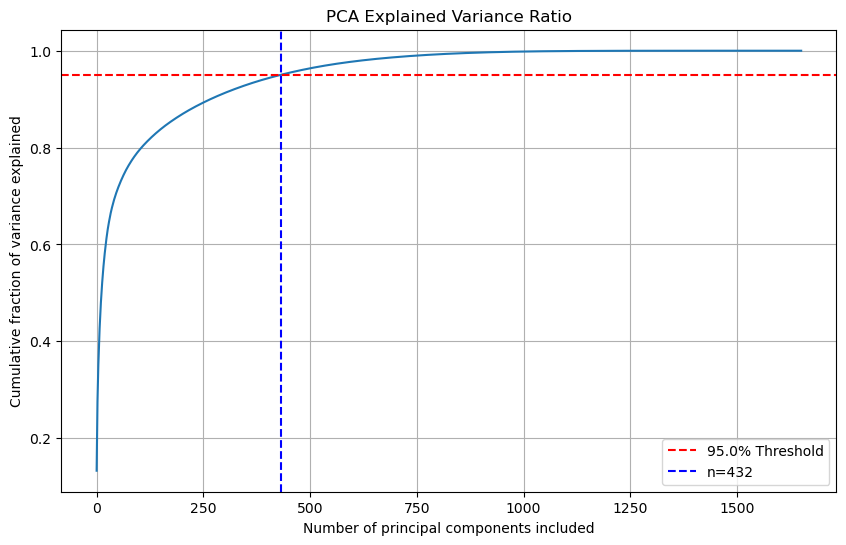

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

def pca_variance_plot(features, variance_threshold=0.95, random_state=42):
    """Perform PCA analysis and create an explained variance plot.

    Args:
        feature_data (pd.DataFrame): DataFrame containing features.
        variance_threshold (float): Cumulative variance threshold. Defaults to 0.95.
        random_state (int): Random seed for reproducibility.

    Returns:
        tuple: A tuple containing:
            - pca_df (pd.DataFrame): DataFrame with PCA-transformed data (gene symbols as index).
            - n_components (int): Number of components needed to reach the variance threshold.
            - pca_object (PCA): Fitted PCA object.
            - fig (matplotlib.figure.Figure): Figure object for the explained variance plot.
    """
    # Copy and scale data
    features = features.copy()
    features = centerscale_by_batch(features)

    # Initialize and fit PCA
    pca = PCA(random_state=random_state)
    pca_transformed = pca.fit_transform(features)

    # Create DataFrame with PCA results
    n_components_total = pca_transformed.shape[1]
    pca_df = pd.DataFrame(
        pca_transformed,
        columns=[f"pca_{n}" for n in range(n_components_total)],
    )

    # Find number of components needed for threshold
    cumsum = pca.explained_variance_ratio_.cumsum()
    n_components = np.argwhere(cumsum >= variance_threshold)[0][0] + 1

    # Create variance plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(cumsum, "-")
    ax.axhline(
        variance_threshold,
        linestyle="--",
        color="red",
        label=f"{variance_threshold * 100}% Threshold",
    )
    ax.axvline(n_components, linestyle="--", color="blue", label=f"n={n_components}")
    ax.set_ylabel("Cumulative fraction of variance explained")
    ax.set_xlabel("Number of principal components included")
    ax.set_title("PCA Explained Variance Ratio")
    ax.grid(True)
    ax.legend()

    print(
        f"Number of components needed for {variance_threshold * 100}% variance: {n_components}"
    )
    print(f"Shape of input data: {features.shape}")

    # Create threshold-limited version
    pca_df_threshold = pca_df[[f"pca_{i}" for i in range(n_components)]]

    print(f"Shape of PCA transformed and reduced data: {pca_df_threshold.shape}")

    return pca_df_threshold, n_components, pca, fig

pca_df_threshold, n_components, pca, fig = pca_variance_plot(features, variance_threshold=0.95)

In [18]:
PC_COUNT = 432

In [19]:
pca_embeddings = embed_by_pca(features.values, metadata, variance_or_ncomp=PC_COUNT, batch_col="batch_values")
pca_embeddings

array([[  2.16230799,  -3.73499411,   0.86959432, ...,   0.35521374,
         -0.50426647,   0.21891347],
       [  6.28158343,  14.80127002,  12.18328088, ...,   0.48598022,
          0.24779631,  -0.30762719],
       [  6.03806432,   8.71708015,   3.74377045, ...,   1.36279862,
          0.96088996,  -0.81630231],
       ...,
       [ -3.38214373, -12.14215156, -23.4300534 , ...,  -0.31119461,
          0.49184491,   0.31799268],
       [ 16.7300028 ,  11.75551951,  -2.94894728, ...,  -0.26450058,
          0.56003144,   0.57041026],
       [-18.82283094,  -4.14959447,   7.39445038, ...,   0.52596526,
         -0.58015915,   0.55929967]])

In [20]:
metadata[PERTURBATION_NAME_COL].value_counts()

gene_symbol_0
nontargeting    522
KLF5             22
DCAF13           21
PHB              21
ARPC4-TTLL3      21
               ... 
TMEM240           1
GIGYF2            1
RACGAP1           1
SPCS2             1
TM7SF2            1
Name: count, Length: 4592, dtype: Int64

In [21]:
tvn_normalized = tvn_on_controls(pca_embeddings, metadata, PERTURBATION_NAME_COL, "nontargeting", "batch_values")
tvn_normalized

array([[ 8.56740389e-02,  7.40918637e-02,  3.59886052e-01, ...,
        -4.50336365e+00, -1.08231392e+00, -4.30262204e+00],
       [ 2.15934169e-01,  2.69802399e-01, -7.37804175e-01, ...,
        -3.06453233e+00, -8.60952574e+00, -5.50360604e-01],
       [-4.37695308e-02, -3.14667288e-01, -1.51246960e-01, ...,
         1.10075798e+01, -7.67338850e+00, -2.79018391e+00],
       ...,
       [-2.84805988e-02, -1.91160381e-01, -2.39790935e-01, ...,
        -4.82085965e-01,  5.07570242e+00,  1.10493788e+01],
       [-7.18781601e-02, -5.79934323e-01, -4.18865242e-01, ...,
         1.60463636e+00,  1.48649509e+00, -6.41630436e+00],
       [ 2.89045784e-03,  4.82494728e-01, -5.47256140e-01, ...,
         2.75030746e+00,  1.41808272e+01,  6.50107034e+00]])